In [2]:
from scipy.interpolate import griddata
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, BatchNormalization

tf.random.set_seed(42)
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import plotly.offline as pyo
from plotly import subplots
import plotly.graph_objects as go

np.random.seed(42)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-01-11 20:07:08.023282: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
client = pd.read_csv("../../data/client.csv")
ePrices = pd.read_csv("../../data/electricity_prices.csv")
gasPrices = pd.read_csv("../../data/gas_prices.csv")
train = pd.read_csv("../../data/train.csv")

weatherPredInt = pd.read_csv("../model_architecture_study/interpolPredWeather.csv")
weatherHistInt = pd.read_csv("../histWeatherSnowCover.csv")

# data processing

In [4]:
producing = train.loc[train.is_consumption == 0]
consuming = train.loc[train.is_consumption == 1]
train = pd.merge(producing.drop('is_consumption',axis = 1), consuming.drop('is_consumption',axis = 1),on=['data_block_id','prediction_unit_id','datetime','county','is_business','product_type'], how='outer',suffixes=('_prod', '_cons'))
del producing, consuming
print(train.shape)

clientsTime = pd.merge(train, client, on=['county','is_business','product_type','data_block_id'], how='inner')

clientsTime['datetime'] = pd.to_datetime(clientsTime['datetime'])
clientsTime['yearday'] = clientsTime['datetime'].dt.day_of_year
clientsTime['weekday'] = clientsTime['datetime'].dt.day_of_week
clientsTime['month'] = clientsTime['datetime'].dt.month
clientsTime['monthday'] = clientsTime['datetime'].dt.day
clientsTime['year'] = clientsTime['datetime'].dt.year
clientsTime['hour'] = clientsTime['datetime'].dt.hour

unique_pairs = list(set(zip(clientsTime['is_business'], clientsTime[ 'product_type'])))
pair_index_dict = {pair: index for index, pair in enumerate(unique_pairs)}
clientsTime['business_prodType'] = list(map(pair_index_dict.get, zip(clientsTime['is_business'], clientsTime['product_type'])))

unique_pairs_cust = list(set(zip(clientsTime['is_business'], clientsTime[ 'product_type'], clientsTime['county'], clientsTime['eic_count'],clientsTime['installed_capacity'])))
pair_index_dict = {pair: index for index, pair in enumerate(unique_pairs_cust)}
clientsTime['ind_customer_id'] = list(map(pair_index_dict.get, zip(clientsTime['is_business'], clientsTime['product_type'], clientsTime['county'], clientsTime['eic_count'],clientsTime['installed_capacity'])))

# interpolate daylight savings
clientsTime = clientsTime.interpolate()

(1009176, 10)


/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_10667/560855032.py:26: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.



In [5]:
import holidays
from datetime import date

us_holidays = holidays.EE()  # this is a dict

clientsTime['holiday'] = clientsTime['datetime'].apply(lambda s : s in us_holidays)
clientsTime['no_workday'] = ((clientsTime['holiday']) | (clientsTime['weekday'] > 4))

In [6]:
ePrices['forecast_date'] = pd.to_datetime(ePrices['forecast_date'])
ePrices['hour'] = ePrices.forecast_date.dt.hour
# Set 'timestamp' as the index
ePrices.set_index('forecast_date', inplace=True)

# Resample to fill missing hours
df_resampled = ePrices.resample('1H').asfreq()

# Linearly interpolate missing values
ePrices = df_resampled.interpolate(method='linear')

ePrices['euros_per_mwh'] = ePrices.euros_per_mwh.replace(4000.0, np.nan)

# Resample to fill missing hours
df_resampled = ePrices.resample('1H').asfreq()

# Linearly interpolate missing values
ePrices = df_resampled.interpolate(method='linear')


/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_10667/1946799552.py:10: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.

/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_10667/1946799552.py:18: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.



In [7]:
clientsTime2 = clientsTime.set_index(['datetime','prediction_unit_id'])

In [8]:
clientsTime2 = pd.merge(clientsTime,ePrices[['data_block_id','hour','euros_per_mwh']], on=['data_block_id','hour'])#.set_index(['datetime','prediction_unit_id'])

In [9]:
clientsTime2 = pd.merge(clientsTime2, gasPrices[['lowest_price_per_mwh','highest_price_per_mwh','data_block_id']], on=['data_block_id'])

In [10]:
clientsTime2.shape

(1004856, 26)

In [11]:
weatherPredInt['hour'] = weatherPredInt['hours_ahead'] - 24
weatherPredInt['county'] = weatherPredInt['County']
weatherPredInt.drop('County',axis = 1, inplace=True)
weatherPredInt.drop('Unnamed: 0', axis = 1, inplace=True)
weatherPredInt.set_index(['forecast_datetime','county'])

latitude  longitude  hours_ahead  \
forecast_datetime         county                                      
2021-09-02 00:00:00+00:00 0       59.310926  24.924348           24   
                          1       58.893253  22.618680           24   
                          2       59.177733  27.327484           24   
                          3       58.940196  25.666667           24   
                          4       58.722191  26.536904           24   
...                                     ...        ...          ...   
2023-05-31 23:00:00+00:00 11      58.392720  26.829967           47   
                          12      58.597500  24.987300           47   
                          13      57.933039  26.143027           47   
                          14      58.336987  25.558364           47   
                          15      57.747955  26.911153           47   

                                  data_block_id            origin_datetime  \
forecast_datetime         county                                             
2021-09-02 00:00:00+00:00 0                   1  2021-09-01 00:00:00+00:00   
                          1                   1  2021-09-01 00:00:00+00:00   
                          2                   1  2021-09-01 00:00:00+00:00   
                          3                   1  2021-09-01 00:00:00+00:00   
                          4                   1  2021-09-01 00:00:00+00:00   
...                                         ...                        ...   
2023-05-31 23:00:00+00:00 11                637  2023-05-30 00:00:00+00:00   
                          12                637  2023-05-30 00:00:00+00:00   
                          13                637  2023-05-30 00:00:00+00:00   
                          14                637  2023-05-30 00:00:00+00:00   
                          15                637  2023-05-30 00:00:00+00:00   

                                  temperatureint  dewpointint  \
forecast_datetime         county                                
2021-09-02 00:00:00+00:00 0            10.067237     5.037243   
                          1            12.167244     5.159730   
                          2             9.417725     6.740294   
                          3             8.882337     5.618534   
                          4             8.830031     5.928326   
...                                          ...          ...   
2023-05-31 23:00:00+00:00 11            9.509761     4.045998   
                          12            8.990915     3.820634   
                          13            9.463768     3.973195   
                          14            8.841315     3.764308   
                          15            9.407044     4.485751   

                                  cloudcover_highint  cloudcover_lowint  \
forecast_datetime         county                                          
2021-09-02 00:00:00+00:00 0                 0.000000           0.121643   
                          1                 0.000000           0.049673   
                          2                 0.000000           0.307994   
                          3                 0.000000           0.307195   
                          4                 0.000000           0.123666   
...                                              ...                ...   
2023-05-31 23:00:00+00:00 11                0.425129           0.000115   
                          12                0.092345           0.000000   
                          13                0.646199           0.000000   
                          14                0.539247           0.000000   
                          15                0.642966           0.000000   

                                  cloudcover_midint  cloudcover_totalint  \
forecast_datetime         county                                           
2021-09-02 00:00:00+00:00 0                0.028473             0.127933   
                          1                0.1

In [12]:
clientsTime3 = pd.merge(clientsTime2, weatherPredInt, on=['county', 'hour','data_block_id'], how='inner', suffixes=('','_pred'))

In [13]:
weatherHistInt['datetime'] = pd.to_datetime(weatherHistInt['datetime'])
weatherHistInt['hour'] = weatherHistInt.datetime.dt.hour
weatherHistInt['county'] = weatherHistInt['County']
weatherHistInt.drop(['Unnamed: 0.1', 'Unnamed: 0','County'], axis = 1, inplace=True)

In [14]:
#move hour timestamp 11 hours up and deal with proper time separation
weatherHistInt['hour_original'] = weatherHistInt.datetime.dt.hour
weatherHistInt['hour'] = weatherHistInt.datetime.dt.hour-11
weatherHistInt['hour'] = weatherHistInt['hour'].apply(lambda s : s+24 if s<0 else s)

weatherHistInt.loc[weatherHistInt.data_block_id == 3].hour.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [15]:
mergedData = pd.merge(clientsTime3, weatherHistInt, on=['county', 'data_block_id', 'hour'], suffixes=('','_hist'))

In [16]:
mergedData.columns

Index(['county', 'is_business', 'product_type', 'target_prod', 'datetime',
       'data_block_id', 'row_id_prod', 'prediction_unit_id', 'target_cons',
       'row_id_cons', 'eic_count', 'installed_capacity', 'date', 'yearday',
       'weekday', 'month', 'monthday', 'year', 'hour', 'business_prodType',
       'ind_customer_id', 'holiday', 'no_workday', 'euros_per_mwh',
       'lowest_price_per_mwh', 'highest_price_per_mwh', 'latitude',
       'longitude', 'forecast_datetime', 'hours_ahead', 'origin_datetime',
       'temperatureint', 'dewpointint', 'cloudcover_highint',
       'cloudcover_lowint', 'cloudcover_midint', 'cloudcover_totalint',
       '10_metre_u_wind_componentint', '10_metre_v_wind_componentint',
       'direct_solar_radiationint', 'surface_solar_radiation_downwardsint',
       'snowfallint', 'total_precipitationint', 'latitude_hist',
       'longitude_hist', 'datetime_hist', 'temperatureint_hist',
       'dewpointint_hist', 'rainint', 'snowfallint_hist',
       'surface_p

In [17]:
mergedData = mergedData.set_index(['ind_customer_id','datetime']).sort_index()

## add time features

In [18]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [19]:
test = mergedData.reset_index().set_index(['datetime'])

In [20]:
frequencies = ["8H","12H","1D","2D","4D","W","2W","3W","M","2M","3M","4M","6M","A"]
orders = [6] * len(frequencies)

# Apply the CalendarFourier transformation for each frequency
fourier_transformed_list = []
for freq, order in zip(frequencies, orders):
    fourier = CalendarFourier(freq=freq, order=order)
    fourier_fit = fourier.in_sample(test.index)
    test = pd.concat([test, pd.DataFrame(fourier_fit, index=test.index)], axis=1)

In [21]:
testF = ['county', 'is_business', 'product_type',
        'prediction_unit_id', 
       'eic_count', 'installed_capacity', 'yearday', 'weekday',
       'month', 'monthday', 'year', 'hour', 'business_prodType', 'holiday',
       'no_workday', 'euros_per_mwh', 'lowest_price_per_mwh',
       'highest_price_per_mwh']
#'target_prod', 'target_cons', 

In [22]:
selected_columns = testF + test.filter(regex='^(cos|sin)').columns.to_list()
selected_columns

['county',
 'is_business',
 'product_type',
 'prediction_unit_id',
 'eic_count',
 'installed_capacity',
 'yearday',
 'weekday',
 'month',
 'monthday',
 'year',
 'hour',
 'business_prodType',
 'holiday',
 'no_workday',
 'euros_per_mwh',
 'lowest_price_per_mwh',
 'highest_price_per_mwh',
 'sin(1,freq=8H)',
 'cos(1,freq=8H)',
 'sin(2,freq=8H)',
 'cos(2,freq=8H)',
 'sin(3,freq=8H)',
 'cos(3,freq=8H)',
 'sin(4,freq=8H)',
 'cos(4,freq=8H)',
 'sin(5,freq=8H)',
 'cos(5,freq=8H)',
 'sin(6,freq=8H)',
 'cos(6,freq=8H)',
 'sin(1,freq=12H)',
 'cos(1,freq=12H)',
 'sin(2,freq=12H)',
 'cos(2,freq=12H)',
 'sin(3,freq=12H)',
 'cos(3,freq=12H)',
 'sin(4,freq=12H)',
 'cos(4,freq=12H)',
 'sin(5,freq=12H)',
 'cos(5,freq=12H)',
 'sin(6,freq=12H)',
 'cos(6,freq=12H)',
 'sin(1,freq=D)',
 'cos(1,freq=D)',
 'sin(2,freq=D)',
 'cos(2,freq=D)',
 'sin(3,freq=D)',
 'cos(3,freq=D)',
 'sin(4,freq=D)',
 'cos(4,freq=D)',
 'sin(5,freq=D)',
 'cos(5,freq=D)',
 'sin(6,freq=D)',
 'cos(6,freq=D)',
 'sin(1,freq=2D)',
 'cos(1,fr

In [23]:
test

,ind_customer_id,county,is_business,product_type,target_prod,data_block_id,row_id_prod,prediction_unit_id,target_cons,row_id_cons,...,"sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(4,freq=A-DEC)","cos(4,freq=A-DEC)","sin(5,freq=A-DEC)","cos(5,freq=A-DEC)","sin(6,freq=A-DEC)","cos(6,freq=A-DEC)"
datetime,,,,,,,,,,,,,,,,,,,,,
2022-11-19 00:00:00,0,5,0,3,1.216,444,1398240,20,198.445,1398241,...,-0.995919,0.090252,-0.796183,-0.605056,-0.179767,-0.983709,0.530730,-0.847541,0.963471,-0.267814
2022-11-19 01:00:00,0,5,0,3,1.680,444,1398378,20,186.166,1398379,...,-0.995789,0.091680,-0.797483,-0.603341,-0.182588,-0.983189,0.527687,-0.849439,0.962309,-0.271958
2022-11-19 02:00:00,0,5,0,3,1.069,444,1398516,20,196.015,1398517,...,-0.995656,0.093109,-0.798779,-0.601624,-0.185408,-0.982662,0.524637,-0.851326,0.961130,-0.276097
2022-11-19 03:00:00,0,5,0,3,0.658,444,1398654,20,201.489,1398655,...,-0.995521,0.094537,-0.800072,-0.599904,-0.188227,-0.982126,0.521581,-0.853202,0.959933,-0.280231
2022-11-19 04:00:00,0,5,0,3,0.612,444,1398792,20,191.141,1398793,...,-0.995385,0.095965,-0.801361,-0.598181,-0.191044,-0.981582,0.518518,-0.855067,0.958718,-0.284359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-19 19:00:00,2115,15,0,3,1.641,536,1697368,58,202.926,1697369,...,0.989728,-0.142960,0.539818,-0.841782,-0.282984,-0.959125,-0.910308,-0.413932,-0.908818,0.417194
2023-02-19 20:00:00,2115,15,0,3,1.570,536,1697500,58,195.100,1697501,...,0.989522,-0.144380,0.538005,-0.842942,-0.285734,-0.958309,-0.911787,-0.410664,-0.907014,0.421101
2023-02-19 21:00:00,2115,15,0,3,1.195,536,1697632,58,193.820,1697633,...,0.989314,-0.145799,0.536190,-0.844097,-0.288482,-0.957485,-0.913253,-0.407392,-0.905193,0.425000


In [24]:
test = test.sort_index()

### linear regression

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

X_train = test[selected_columns]
y_train = test['target_prod']

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.5)

# Create a linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

/Users/matthiaskargl/opt/anaconda3/envs/predictenegycons/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/matthiaskargl/opt/anaconda3/envs/predictenegycons/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/matthiaskargl/opt/anaconda3/envs/predictenegycons/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/matthiaskargl/opt/anaconda3/envs/predictenegycons/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` in

LinearRegression()

In [32]:
# Make predictions on the test set
y_pred = model.predict(X_train)

# Calculate mean absolute error
mae = mean_absolute_error(y_train, y_pred)

# Print the mean absolute error
print(f'Mean Absolute Error train: {mae}')

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate mean absolute error
mae = mean_absolute_error(y_test, y_pred)

# Print the mean absolute error
print(f'Mean Absolute Error test: {mae}')

/Users/matthiaskargl/opt/anaconda3/envs/predictenegycons/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/matthiaskargl/opt/anaconda3/envs/predictenegycons/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/matthiaskargl/opt/anaconda3/envs/predictenegycons/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/matthiaskargl/opt/anaconda3/envs/predictenegycons/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` in

Mean Absolute Error train: 142.28029631458858
Mean Absolute Error test: 143.08978501798975


/Users/matthiaskargl/opt/anaconda3/envs/predictenegycons/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/matthiaskargl/opt/anaconda3/envs/predictenegycons/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



### simple nn

In [34]:
mergedData.columns

Index(['county', 'is_business', 'product_type', 'target_prod', 'data_block_id',
       'row_id_prod', 'prediction_unit_id', 'target_cons', 'row_id_cons',
       'eic_count', 'installed_capacity', 'date', 'yearday', 'weekday',
       'month', 'monthday', 'year', 'hour', 'business_prodType', 'holiday',
       'no_workday', 'euros_per_mwh', 'lowest_price_per_mwh',
       'highest_price_per_mwh', 'latitude', 'longitude', 'forecast_datetime',
       'hours_ahead', 'origin_datetime', 'temperatureint', 'dewpointint',
       'cloudcover_highint', 'cloudcover_lowint', 'cloudcover_midint',
       'cloudcover_totalint', '10_metre_u_wind_componentint',
       '10_metre_v_wind_componentint', 'direct_solar_radiationint',
       'surface_solar_radiation_downwardsint', 'snowfallint',
       'total_precipitationint', 'latitude_hist', 'longitude_hist',
       'datetime_hist', 'temperatureint_hist', 'dewpointint_hist', 'rainint',
       'snowfallint_hist', 'surface_pressureint', 'cloudcover_totalint_hist

In [56]:
testF2 = ['county', 'is_business', 'product_type',
        'prediction_unit_id', 
       'eic_count', 'installed_capacity', 'yearday', 'weekday',
       'month', 'monthday', 'year', 'hour', 'business_prodType', 'holiday',
       'no_workday', 'euros_per_mwh', 'lowest_price_per_mwh',
       'highest_price_per_mwh',
       #'latitude', 'longitude', 'forecast_datetime',
       #'hours_ahead', 'origin_datetime', 
       'temperatureint', 'dewpointint',
       'cloudcover_highint', 'cloudcover_lowint', 'cloudcover_midint',
       'cloudcover_totalint', 
       #'10_metre_u_wind_componentint','10_metre_v_wind_componentint', 
       'direct_solar_radiationint',
       'surface_solar_radiation_downwardsint', 'snowfallint',
       'total_precipitationint', 
       #'latitude_hist', 'longitude_hist',
       #'datetime_hist', 'temperatureint_hist', 'dewpointint_hist', 'rainint',
       #'snowfallint_hist', 'surface_pressureint', 'cloudcover_totalint_hist',
       #'cloudcover_lowint_hist', 'cloudcover_midint_hist',
       #'cloudcover_highint_hist', 'windspeed_10mint', 'winddirection_10mint',
       #'shortwave_radiationint', 'direct_solar_radiationint_hist',
       #'diffuse_radiationint', 'meltingInCM', 'snowHeightFlux', 
       'snowcover',
       #'hour_original'
       'target_prod'
]

selected_columns2 = testF2+ test.filter(regex='^(cos|sin)').columns.to_list()

In [57]:
splitIdx = int(test.shape[0]/24 * 0.6)*24
train1 = test.iloc[0:splitIdx,:]
test1 = test.iloc[splitIdx:-1,:]

train1 = test.loc[test.forecast_datetime < '2022-09-23 00:00:00+00:00']
test1 = test.loc[test.forecast_datetime >= '2022-09-23 00:00:00+00:00']

In [58]:
X_train = train1[selected_columns2].to_numpy().reshape(-1,24,len(selected_columns2))
y_train = train1['target_cons'].to_numpy().reshape(-1,24,1)
X_test = test1[selected_columns2].to_numpy().reshape(-1,24,len(selected_columns2))
y_test = test1['target_cons'].to_numpy().reshape(-1,24,1)

#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.5)
X_train = X_train.astype(float)
X_test = X_test.astype(float)

In [59]:
weatherPred_inputs2 = tf.keras.Input(shape=(24,X_train.shape[2]), name='weatherPred_inputs2')

x = BatchNormalization()(weatherPred_inputs2)
#x = layers.Flatten()(x)
#x  = layers.Dense(int(x.shape[1]), activation='relu')(x)
for i in range(0,3):
    #x  = layers.Dense(int(x.shape[1]), activation='relu')(x)
    x  = layers.Dense(int(197), activation='relu')(x)
    print(x.shape)

for i in range(0,2):
    x  = layers.Dense(int(x.shape[1]/(i+1)), activation='relu')(x)
    print(x.shape)


    #x = layers.Dropout(0.1)(x)
output_layer2 = layers.Dense(24, activation='relu')(x)

model3 = tf.keras.Model(inputs=weatherPred_inputs2, outputs=output_layer2)


model3.compile(optimizer='adam', loss='mae')#, metrics=custom_metric)#absolute_loss, metrics=['mae'])
# 0 = cons, 1 = prod
history3 = model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=50)

(None, 24, 197)
(None, 24, 197)
(None, 24, 197)
(None, 24, 24)
(None, 24, 12)
Epoch 1/30
502/502 [==============================] - 8s 15ms/step - loss: 232.6999 - val_loss: 654.4349
Epoch 2/30
502/502 [==============================] - 7s 13ms/step - loss: 163.8698 - val_loss: 205.1142
Epoch 3/30
502/502 [==============================] - 7s 13ms/step - loss: 97.2843 - val_loss: 151.6096
Epoch 4/30
502/502 [==============================] - 7s 13ms/step - loss: 80.0592 - val_loss: 157.9990
Epoch 5/30
502/502 [==============================] - 7s 14ms/step - loss: 71.5821 - val_loss: 127.1159
Epoch 6/30
502/502 [==============================] - 7s 14ms/step - loss: 66.2624 - val_loss: 143.5874
Epoch 7/30
502/502 [==============================] - 7s 14ms/step - loss: 61.4332 - val_loss: 141.0230
Epoch 8/30
502/502 [==============================] - 7s 14ms/step - loss: 58.0959 - val_loss: 117.1294
Epoch 9/30
502/502 [==============================] - 7s 14ms/step - loss: 55.4327 - val

In [35]:
history3 = model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=50)

Epoch 1/10
502/502 [==============================] - 10s 20ms/step - loss: 29.2443 - val_loss: 38.9305
Epoch 2/10
502/502 [==============================] - 10s 21ms/step - loss: 26.0293 - val_loss: 38.8481
Epoch 3/10
502/502 [==============================] - 11s 22ms/step - loss: 25.3035 - val_loss: 37.2801
Epoch 4/10
502/502 [==============================] - 10s 20ms/step - loss: 23.6719 - val_loss: 38.9347
Epoch 5/10
502/502 [==============================] - 10s 20ms/step - loss: 23.5356 - val_loss: 41.9781
Epoch 6/10
502/502 [==============================] - 10s 20ms/step - loss: 22.7251 - val_loss: 39.7196
Epoch 7/10
502/502 [==============================] - 10s 20ms/step - loss: 22.2906 - val_loss: 40.6260
Epoch 8/10
502/502 [==============================] - 10s 20ms/step - loss: 22.1403 - val_loss: 40.3507
Epoch 9/10
502/502 [==============================] - 10s 20ms/step - loss: 21.6263 - val_loss: 38.6550
Epoch 10/10
502/502 [==============================] - 11s 21ms/

In [60]:
fig = go.Figure()
length = len(history3.history['loss'])
fig.add_trace(go.Scatter(x=np.arange(1, length+1), y=history3.history['loss'], mode='lines', name='Train Loss'))
fig.add_trace(go.Scatter(x=np.arange(1, length+1), y=history3.history['val_loss'], mode='lines', name='Validation Loss'))
fig.update_layout(
    title='Training and Validation Loss Over Epochs',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(x=0, y=1, traceorder='normal'),
)
fig.show()

In [ ]:
# daily predictions time wise test/train split

# PRODUCTION
#   with fourier features
#       33/45 with 10 epochs batch size 50
#       26/37 20 epochs (batch 50)
#       31/93 10 epochs (batch size 500)
#       21/38 30 epochs (batch size 500)

#   flattend layer with fourier
#       40/55 after 30 epochs (500 batch size)
#       68/74 after 10 epochs (50 batch size)

#   without fourier features
#       35/46 10 epochs batch size 50
#       30/47 30 epochs batch size 500

#   flatten layer without fourier
#       53/70 30 epochs batch size 500


# CONSUMPTION

#   with fourier featuers
#       59/152 30 epochs, batch size 500
#       62/132 30 epochs, batch size 50 overfitted at like 8 epochs, after 34/151

#   with prod target!
#       58/117 30 epochs, batch size 50 overfitted at like 8 epochs after 32/145

#   without fourier features
#       77/166 30 epochs batch size 500 (starting to overfit)

#   flatten layer without fourier
#       227/316 30 epochs batch size 500


In [ ]:
# hourly predictions! time wise test/train split

# PRODUCTION
#   with fourier features
#       22/41 (after overfit) with 10 epochs & 5000 batch size
#       21/38 (only overfit after around 8 epochs) 100 epochs & 5000 batch size (in the end 12/42)

#   without fourier features
#       23/55 with 10 epochs & 5000 batch size

# CONSUMPTION
#   with fourier features
#       58/143 with 10 epochs (5000 batch size) (starting to overfit)

#   without fourier features
#       63/142 with 10 epochs (5000 batch size) (starting to overfit)

In [ ]:
# hourly predictions! ATTENTION: random test/train split

#PRODUCTION
#   fourier features
#       23/25 after 10 epochs (5000 batch) with fourier features 

#   without fourier features
#       26/26 after 100 epochs (5000 batch) without fourier features (& way smaller network bc less features)
#       27/26 after 10 epochs (5000 batch) with same network size as fourier featurs but no fourier features
#       17.7/19.3 after 100 epocth (5000 batch) witz same size as fourier,

#CONSUMPTION
#   fourier featuers
#       72/86 after 10 epochs (5000 batch)

#   without fourier features
#       78/80 after 10 epochs (5000 batch)
#       40/40 after 100 epochs (5000 batch)

# analyze data

In [102]:
from pathlib import Path
#from learntools.time_series.utils import plot_lags, make_lags, make_leads

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

## periodogram

In [178]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1D") / pd.Timedelta("1H")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([
        #1, 2, 4, 6, 12, 26, 52, 104,365,730,876,1095,1460,1752,2190,2920,4380,8760
        1/8760, 1/4380, 1/2920, 1/1460, 1/730, 1/336,1/168,1/84, 1/56, 1/42,1,2,3,4,6,8,12,24, 
        ])
    ax.set_xticklabels(
        [
            #"Annual (1)",
            #"Semiannual (2)",
            #"Quarterly (4)",
            #"Bimonthly (6)",
            #"Monthly (12)",
            #"Biweekly (26)",
            #"Weekly (52)",
            #"Semiweekly (104)",
            'yearly',
            'biyearly',
            'thirdyearly',
            'bimonthly',
            'monthly',
            'biweekly',
            'weekly',
            'halfweekly',
            'thirdweekly',
            'quarterweekly',
            "daily",
            "12h",
            #"10h",
            "8h",
            "6h",
            #"5h",
            "4h",
            "3h",
            '2h',
            '1h'
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

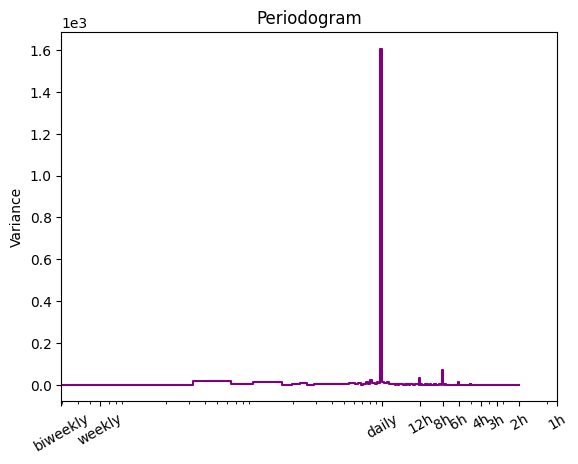

In [171]:
plot_periodogram(mergedData.loc[1,:].target_cons)

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

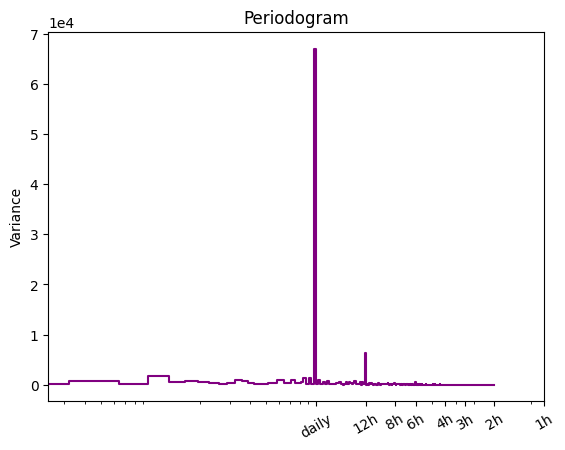

In [166]:
plot_periodogram(mergedData.loc[1,:].target_prod)

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

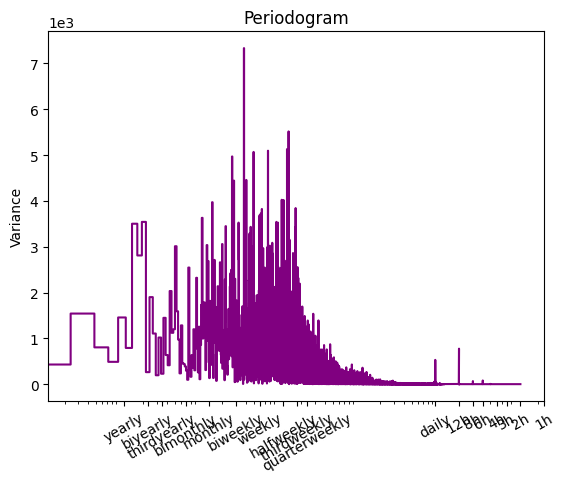

In [179]:
plot_periodogram(mergedData.target_cons)

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

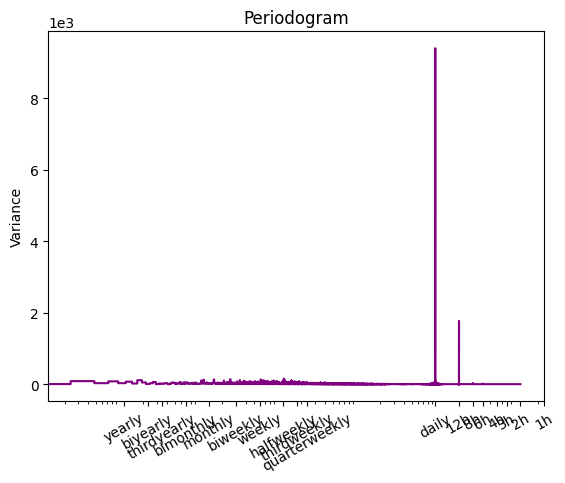

In [180]:
plot_periodogram(mergedData.target_prod)

## lag features

production lag feature: 
- 1 & 2 lag has massive correlation
- betwen 10-20 also big correlation but not as important since probably FP

consumption lag feature:
- 1,2,3 big correlation
- around 24h has big correlation
- around 48 has big correlation, old target data might help for consumption


seems to be a linear correlation between them, consumption has way more correlation in later time (available)

probably not helpful since not availalbe

TODO:
try lag features for weather & gas/electricity price data

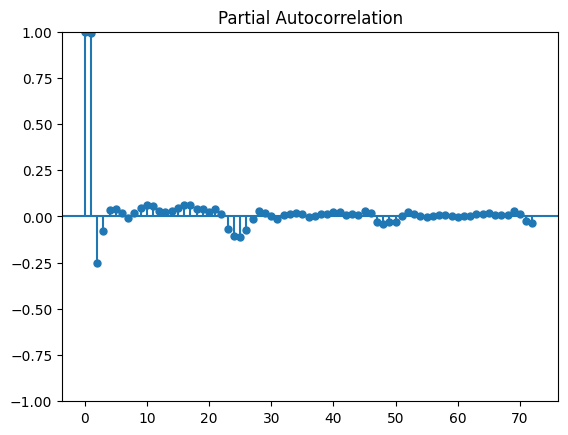

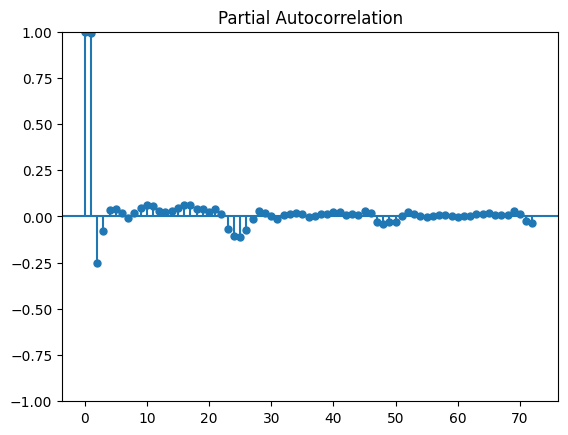

In [112]:
plot_pacf(mergedData.target_cons, lags=72)

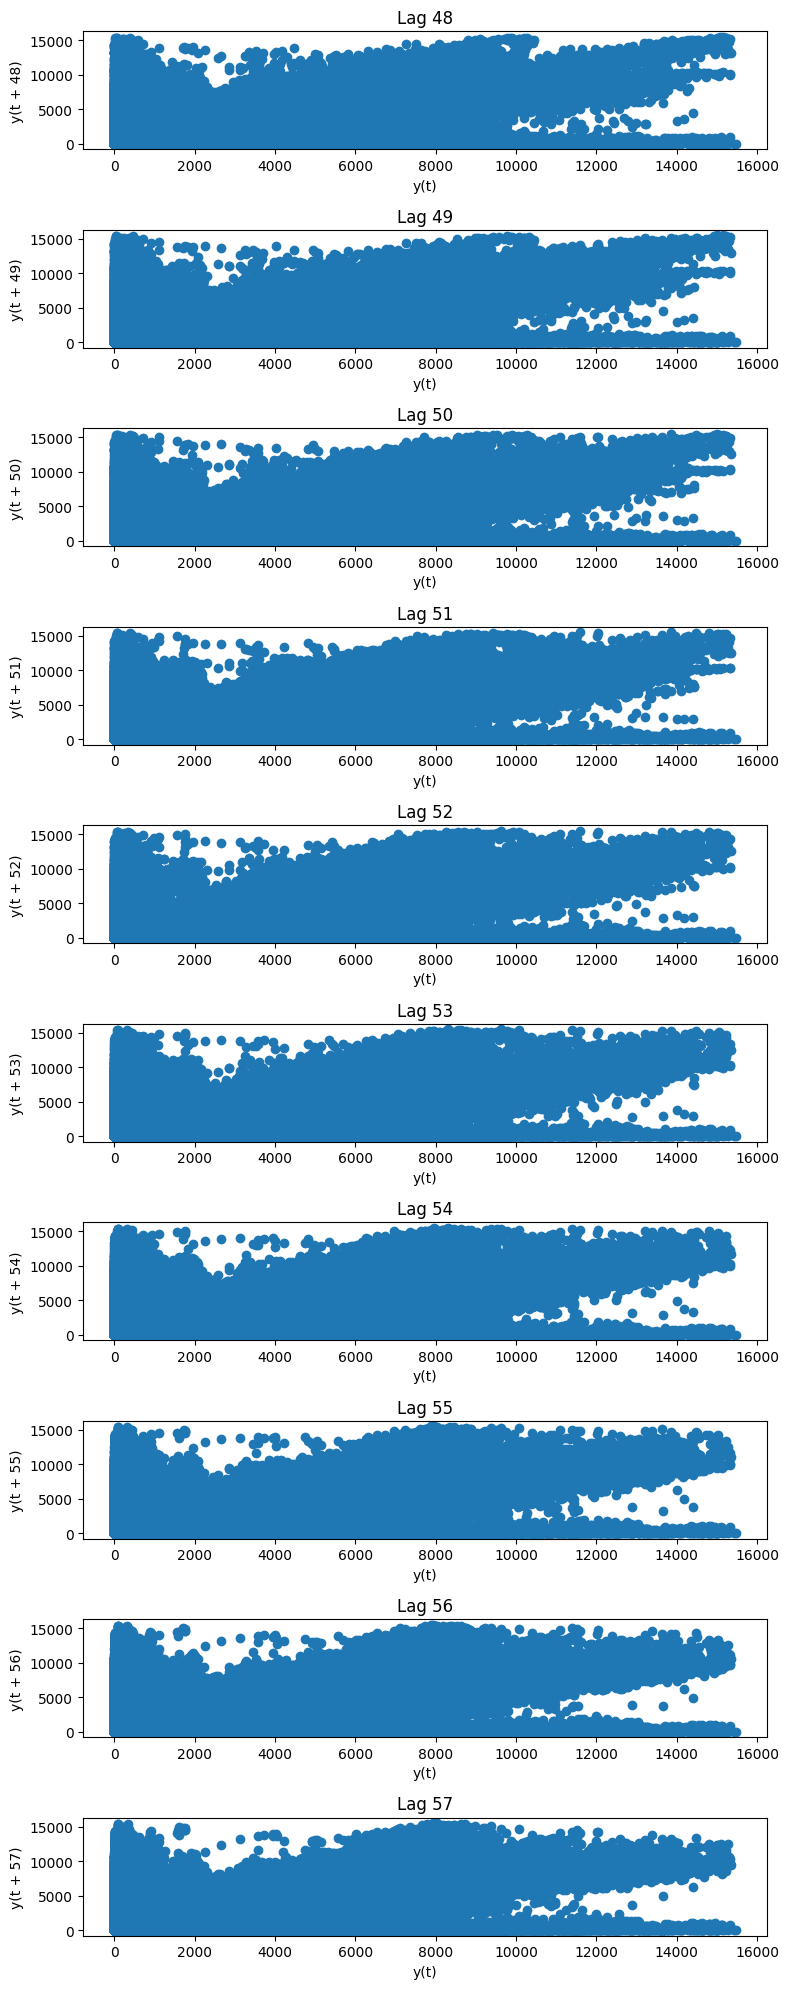

In [121]:
num_lags = 10

# Create a subplot with multiple lag plots
fig, axes = plt.subplots(nrows=num_lags, ncols=1, figsize=(8, 2*num_lags))

# Iterate over lags and plot
for lag in range(1, num_lags + 1):
    lag = lag + 47
    pd.plotting.lag_plot(mergedData['target_cons'], lag=lag, ax=axes[lag-1-47])
    axes[lag-1-47].set_title(f'Lag {lag}')

plt.tight_layout()
plt.show()

## rolling

Text(0.5, 1.0, 'Moving Average')

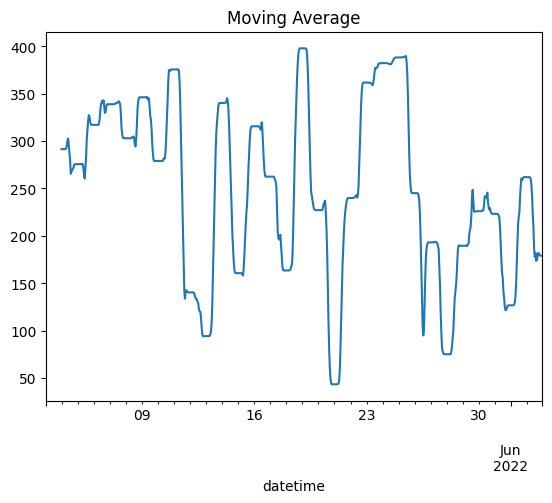

In [105]:
# rolling mean
cons_ma = mergedData.loc[1,:].target_prod.rolling(24).mean()
ax = cons_ma.plot()
ax.set_title("Moving Average")

#

# training a model

In [122]:
mergedData.columns

Index(['county', 'is_business', 'product_type', 'target_prod', 'data_block_id',
       'row_id_prod', 'prediction_unit_id', 'target_cons', 'row_id_cons',
       'eic_count', 'installed_capacity', 'date', 'yearday', 'weekday',
       'month', 'monthday', 'year', 'hour', 'business_prodType',
       'euros_per_mwh', 'lowest_price_per_mwh', 'highest_price_per_mwh',
       'latitude', 'longitude', 'forecast_datetime', 'hours_ahead',
       'origin_datetime', 'temperatureint', 'dewpointint',
       'cloudcover_highint', 'cloudcover_lowint', 'cloudcover_midint',
       'cloudcover_totalint', '10_metre_u_wind_componentint',
       '10_metre_v_wind_componentint', 'direct_solar_radiationint',
       'surface_solar_radiation_downwardsint', 'snowfallint',
       'total_precipitationint', 'latitude_hist', 'longitude_hist',
       'datetime_hist', 'temperatureint_hist', 'dewpointint_hist', 'rainint',
       'snowfallint_hist', 'surface_pressureint', 'cloudcover_totalint_hist',
       'cloudcover_low